<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Homework 3</div>

$\textbf{Auteurs}$ : Adel Nabli, Myriam Laiymani

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import utils.mnist_reader as mnist_reader

In [2]:
data = np.loadtxt(open('cercle.txt','r'))
data_train = data[:1000]
data_train[:, -1] += 1
data_train[:, -1] /= 2
data_test = data[1000:]
data_test[:, -1] += 1
data_test[:, -1] /= 2
Xc_train, yc_train = data_train[:,:2], data_train[:,-1]
Xc_test, yc_test = data_test[:,:2], data_test[:,-1]

X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
data_train_mnist = np.concatenate((X_train, np.reshape(y_train, (len(y_train),1))), axis=1)
data_test_mnist = np.concatenate((X_test, np.reshape(y_test, (len(y_test),1))), axis=1)

# Quelques fonctions utiles


### La fonction softmax

In [3]:
def softmax(X):
    
    """Compute the softmax of a given matrix"""
    
    return(np.exp(X - np.log(np.sum(np.exp(X), axis=0))))

### La fonction RELU

In [4]:
def RELU(X):
    
    """Compute the RELU function for a given matrix"""
    
    return(np.maximum(0, X))

# Méthode avec boucle (Questions 1 à 5)

Pour calculer les gradients, il faut suivre les étapes suivantes:

* Initialiser les paramètres
* Faire la forward propagation
* Faire la backward propagation
* Verifier que les calculs sont bons par Gradient Checking

Or, pour le gradient checking, il nous faut une fonction qui puisse calculer la perte, nous allons donc devoir en coder une.

Rappelons que les différents gradients sont:

* $\dfrac{\partial L}{\partial b^{(2)}} = -onehot_m(y) + o^s \in \mathbb{R}^{m}$

* $\dfrac{\partial L}{\partial W^{(2)}} = \dfrac{\partial L}{\partial b^{(2)}}(h^s)^T \; \in \mathbb{R}^{m \times d_h}$

* $\dfrac{\partial L}{\partial h^s} = \underbrace{W^{(2)T}}_{\in \; \mathbb{R}^{d_h \times m}}\dfrac{\partial L}{\partial b^{(2)}} \; \in \; \mathbb{R}^{d_h}$

* $\dfrac{\partial L}{\partial b^{(1)}} = \underbrace{\dfrac{\partial L}{\partial h^s}}_{\in \; \mathbb{R}^{d_h}}*\underbrace{1_{x>0}(h^a)}_{\in \; \mathbb{R}^{d_h}} \; \in \; \mathbb{R}^{d_h}$

* $\dfrac{\partial L}{\partial W^{(1)}} = \dfrac{\partial L}{\partial b^{(1)}}x^T \; \in \mathbb{R}^{d_h \times d}$

## Question 1&2

In [5]:
def initialize_parameters(d, dh, m):
    
    """Initialize the parameters of our Neural Network"""
    
    W1 = np.random.uniform(low=(-1/np.sqrt(d)), high=(1/np.sqrt(d)), size=(dh,d))
    b1 = np.zeros((dh,1))
    W2 = np.random.uniform(low=(-1/np.sqrt(dh)), high=(1/np.sqrt(dh)), size=(m,dh))
    b2 = np.zeros((m,1))
    
    parameters = {'W1': W1, 'b1': b1, 'b2': b2, 'W2': W2}
    
    return(parameters)

def fprop_1d(x, parameters):
        
    """Execute the forward propagation"""

    ha = parameters['W1'].dot(x) + parameters['b1']
    hs = RELU(ha)
    oa = parameters['W2'].dot(hs) + parameters['b2']
    os = softmax(oa)
    
    cache = {'ha': ha, 'hs': hs, 'oa' : oa, 'os' :os}
    
    return(cache)

def bprop_1d(x, y, parameters, cache, regularize=False, Lambda=[0,0,0,0]):
        
    """Execute the backward propagation for 1 example"""
        
    grad_b2 = cache['os'] - np.reshape([int(i==y) for i in range(len(cache['os']))], (len(cache['os']),1))
    grad_W2 = grad_b2.dot(cache['hs'].T)
    grad_hs = parameters['W2'].T.dot(grad_b2)
    grad_b1 = grad_hs * (cache['ha']>0)
    grad_W1 = grad_b1.dot(x.T)
    
    # If we have a regularizaion term
        
    if regularize:
            
        grad_W2 += Lambda[2]*(1*(parameters['W2'] > 0) - 1*(parameters['W2'] <0)) + Lambda[3]*2*parameters['W2']
        grad_W1 += Lambda[0]*(1*(parameters['W1'] > 0) - 1*(parameters['W1'] <0)) + Lambda[1]*2*parameters['W1']
    
    grads = {'b2': grad_b2, 'W2': grad_W2, 'b1': grad_b1, 'W1': grad_W1, 'hs': grad_hs}
    
    return(grads)

def loss_1d(y, os, regularize=False, Lambda=[0,0,0,0], parameters = {}):
        
    """Compute the loss $\tilde{R}$ for a given output vector of probability os and the true y"""
    
    loss = -float(np.log(os[int(y)]))
    
    if regularize:
        
        loss += Lambda[0]*np.sum(np.abs(parameters['W1'])) + Lambda[1]*np.sum(parameters['W1']*parameters['W1']) + Lambda[2]*np.sum(np.abs(parameters['W2'])) + Lambda[3]*np.sum(parameters['W2']*parameters['W2'])
    
    return(loss)
    
def gradient_checking_1d(x, y, parameters, epsilon):
    
    cache = fprop_1d(x, parameters)
    os = cache['os']
    loss = loss_1d(y, os)
    true_grads = bprop_1d(x, y, parameters, cache)
    
    for param in parameters.keys():
        
        estimated_gradient = np.zeros(np.shape(parameters[param]))
        ratio = np.zeros(np.shape(parameters[param]))
        
        for i in range(parameters[param].shape[0]):
            
            for j in range(parameters[param].shape[1]):
                
                # We compute the forward propagation and the loss for a change in one parameter
        
                parameters_epsilon = copy.deepcopy(parameters)
                parameters_epsilon[param][i,j] += epsilon
                os_epsilon = fprop_1d(x, parameters_epsilon)['os']
                loss_epsilon = loss_1d(y, os_epsilon)
        
                # We compute the estimated gradient
        
                estimated_gradient[i,j] = (loss_epsilon - loss)/epsilon
            
                # We compute the ratio
                
                ratio[i,j] = estimated_gradient[i,j]/true_grads[param][i,j]
        
        print('\n The true gradient for the parameter %s : \n' %param, true_grads[param])
        print('\n The estimated gradient for the parameter %s : \n' %param, estimated_gradient)
        print('\n The ratio between the two grads for the parameter %s : \n' %param, ratio)

In [16]:
x, y = Xc_train[0], yc_train[0]
x = np.reshape(x, (len(x),1))
parameters = initialize_parameters(2, 2, 2)
gradient_checking_1d(x, y, parameters, 1e-5)


 The true gradient for the parameter W1 : 
 [[ 0.29787656 -0.28182156]
 [-0.18937933  0.17917213]]

 The estimated gradient for the parameter W1 : 
 [[ 0.297877   -0.28182117]
 [-0.18937916  0.17917229]]

 The ratio between the two grads for the parameter W1 : 
 [[1.00000146 0.99999862]
 [0.99999907 1.00000088]]

 The true gradient for the parameter b1 : 
 [[ 0.22068429]
 [-0.14030323]]

 The estimated gradient for the parameter b1 : 
 [[ 0.22068453]
 [-0.14030313]]

 The ratio between the two grads for the parameter b1 : 
 [[1.00000108]
 [0.99999931]]

 The true gradient for the parameter b2 : 
 [[ 0.50498663]
 [-0.50498663]]

 The estimated gradient for the parameter b2 : 
 [[ 0.50498788]
 [-0.50498538]]

 The ratio between the two grads for the parameter b2 : 
 [[1.00000248]
 [0.99999752]]

 The true gradient for the parameter W2 : 
 [[ 0.06220098  0.06158102]
 [-0.06220098 -0.06158102]]

 The estimated gradient for the parameter W2 : 
 [[ 0.062201    0.06158104]
 [-0.06220096 -0.0

### Question 3&4

On doit maintenant gérer le cas de $K$ exemples avec une boucle. On va donc copier les fonctions à modifier et faire les ajouts nécessaires. Rappelons nous que sans régularisation, la fonction à minimiser n'est pas $L$ mais bien $\hat{R} = \dfrac{1}{K} \sum_{i=1}^K L(x^{(i)}, y^{(i)})$ et que donc les $\textit{gradients finaux}$ sont la moyenne de ceux calculés pour chaque donnée.

In [7]:
def fprop_1d_K(X, parameters):
        
    """Execute the forward propagation"""
    
    cache = []
    
    for x_i in X:
        
        x = np.reshape(x_i, (len(x_i),1))
        
        ha = parameters['W1'].dot(x) + parameters['b1']
        hs = RELU(ha)
        oa = parameters['W2'].dot(hs) + parameters['b2']
        os = softmax(oa)
    
        cache.append({'ha': ha, 'hs': hs, 'oa' : oa, 'os' :os})
    
    return(cache)

def bprop_1d_K(X, Y, parameters, cache, regularize=False, Lambda=[0,0,0,0]):
        
    """Execute the backward propagation for K examples"""
    
    K = len(Y)
    
    d = len(X[0])
    dh = len(parameters['b1'])
    m = len(parameters['b2'])
    
    grad_b2 = np.zeros((m,1))
    grad_W2 = np.zeros((m,dh))
    grad_hs = np.zeros((dh,1))
    grad_b1 = np.zeros((dh,1))
    grad_W1 = np.zeros((dh,d))
    
    for j in range(K):
        
        grad_b2_j = cache[j]['os'] - np.reshape([int(i==Y[j]) for i in range(len(cache[j]['os']))], (len(cache[j]['os']),1))
        grad_W2_j = grad_b2_j.dot(cache[j]['hs'].T)
        grad_hs_j = parameters['W2'].T.dot(grad_b2_j)
        grad_b1_j = grad_hs_j * (cache[j]['ha']>0)
        x = np.reshape(X[j], (len(X[j]),1))
        grad_W1_j = grad_b1_j.dot(x.T)
        
        grad_b2 += grad_b2_j
        grad_W2 += grad_W2_j
        grad_hs += grad_hs_j
        grad_b1 += grad_b1_j
        grad_W1 += grad_W1_j
    
    grad_b2 /= K
    grad_W2 /= K
    grad_hs /= K
    grad_b1 /= K
    grad_W1 /= K
    
    # If we have a regularizaion term
        
    if regularize:
            
        grad_W2 += Lambda[2]*(1*(parameters['W2'] > 0) - 1*(parameters['W2'] <0)) + Lambda[3]*2*parameters['W2']
        grad_W1 += Lambda[0]*(1*(parameters['W1'] > 0) - 1*(parameters['W1'] <0)) + Lambda[1]*2*parameters['W1']
    
    grads = {'b2': grad_b2, 'W2': grad_W2, 'b1': grad_b1, 'W1': grad_W1, 'hs': grad_hs}
    
    return(grads)

def loss_1d_K(Y, cache, regularize=False, Lambda=[0,0,0,0], parameters = {}):
        
    """Compute the loss $\tilde{R}$ for a given output vector of probability os and the true y"""
    
    K = len(Y)
    loss = 0
    
    for j in range(K):
        
        os = cache[j]['os']
        y = Y[j]
        loss -= float(np.log(os[int(y)]))
    
    loss /= K
    
    if regularize:
        
        loss += Lambda[0]*np.sum(np.abs(parameters['W1'])) + Lambda[1]*np.sum(parameters['W1']*parameters['W1']) + Lambda[2]*np.sum(np.abs(parameters['W2'])) + Lambda[3]*np.sum(parameters['W2']*parameters['W2'])
    
    return(loss)
    
def gradient_checking_1d_K(X, Y, parameters, epsilon):
    
    cache = fprop_1d_K(X, parameters)
    loss = loss_1d_K(Y, cache)
    true_grads = bprop_1d_K(X, Y, parameters, cache)
    
    for param in parameters.keys():
        
        estimated_gradient = np.zeros(np.shape(parameters[param]))
        ratio = np.zeros(np.shape(parameters[param]))
        
        for i in range(parameters[param].shape[0]):
            
            for j in range(parameters[param].shape[1]):
                
                # We compute the forward propagation and the loss for a change in one parameter
        
                parameters_epsilon = copy.deepcopy(parameters)
                parameters_epsilon[param][i,j] += epsilon
                cache = fprop_1d_K(X, parameters_epsilon)
                loss_epsilon = loss_1d_K(Y, cache)
        
                # We compute the estimated gradient
        
                estimated_gradient[i,j] = (loss_epsilon - loss)/epsilon
            
                # We compute the ratio
                
                ratio[i,j] = estimated_gradient[i,j]/true_grads[param][i,j]
        
        print('\n The true gradient for the parameter %s : \n' %param, true_grads[param])
        print('\n The estimated gradient for the parameter %s : \n' %param, estimated_gradient)
        print('\n The ratio between the two grads for the parameter %s : \n' %param, ratio)

In [8]:
x, y = Xc_train[:10], yc_train[:10]
parameters = initialize_parameters(2, 2, 2)
gradient_checking_1d_K(x, y, parameters, 1e-5)


 The true gradient for the parameter W1 : 
 [[-0.01582565  0.0160922 ]
 [ 0.01370027  0.0649131 ]]

 The estimated gradient for the parameter W1 : 
 [[-0.01582553  0.01609226]
 [ 0.01370063  0.06491337]]

 The ratio between the two grads for the parameter W1 : 
 [[0.99999217 1.00000374]
 [1.00002627 1.00000421]]

 The true gradient for the parameter b1 : 
 [[0.00110748]
 [0.01495923]]

 The estimated gradient for the parameter b1 : 
 [[0.00110755]
 [0.01495942]]

 The ratio between the two grads for the parameter b1 : 
 [[1.00006481]
 [1.00001263]]

 The true gradient for the parameter b2 : 
 [[ 0.04078587]
 [-0.04078587]]

 The estimated gradient for the parameter b2 : 
 [[ 0.04078709]
 [-0.04078464]]

 The ratio between the two grads for the parameter b2 : 
 [[1.00003003]
 [0.99996997]]

 The true gradient for the parameter W2 : 
 [[ 0.06534015  0.00279866]
 [-0.06534015 -0.00279866]]

 The estimated gradient for the parameter W2 : 
 [[ 0.06534097  0.00279868]
 [-0.06533934 -0.00279

### Question 5

On va implémenter l'algorithme de descente de gradient en utilisant les fonctions définies à la question précédente

In [25]:
def gradient_descent(data_train, dh, K, n_epoch, learning_rate, use_regularization=False, lmbda=[0,0,0,0]):
    
    """Use the gradient descent algorithm to train the Neural Network"""
    
    t1 = time.time()
    d = np.shape(data_train)[1] - 1
    m = int(max(data_train[:,-1]) + 1)
    parameters = initialize_parameters(d, dh, m)
    loss = []
    
    for t in range(n_epoch):
        
        np.random.shuffle(data_train)
        X_train, Y_train = data_train[:,:d], data_train[:,-1]
        n = len(Y_train)
        
        for k in range(n//K):
            
            X, Y = X_train[k*K:(k+1)*K], Y_train[k*K:(k+1)*K]
            cache = fprop_1d_K(X, parameters)
            grads = bprop_1d_K(X, Y, parameters, cache, regularize=use_regularization, Lambda=lmbda)
            
            for param in parameters.keys():
                
                parameters[param] -= learning_rate * grads[param]
        
        cache = fprop_1d_K(X_train, parameters)
        loss.append(loss_1d_K(Y_train, cache, regularize=use_regularization, Lambda=lmbda, parameters=parameters))
    
    t2 = time.time()
    print('\n Duration of the training = ', t2-t1, ' seconds \n')
    print('\n Mean duration of an epoch = ', (t2-t1)/n_epoch, ' seconds \n')
    
    return(parameters, loss)

def plot_decision_boundary(data, parameters):
    
    X, y = data[:, :2], data[:, -1]
    y_predict = []
    y_echantillonage = []
    cache1 = fprop_1d_K(X, parameters)
    
    for k in range(len(X)):
        
        y_predict.append(cache1[k]['os'][0])
    
    y_predict= 1*(np.array(y_predict)<0.5)
    y_predict = y_predict.flatten()
    
    accuracy = np.mean(np.array(1*(y==y_predict)))
    plt.scatter(X[:,0], X[:,1], c=y)
    
    # We create a 2-d grid
    
    borne_inf = np.min(X)
    borne_sup = np.max(X)
    x1 = np.linspace(borne_inf, borne_sup, 200)
    x2 = np.linspace(borne_inf, borne_sup, 200)
    X_echantillonage = np.reshape([[[i,j] for i in x1] for j in x2], (len(x1)*len(x2), 2))
    cache2 = fprop_1d_K(X_echantillonage, parameters)
    
    for k in range(len(X_echantillonage)):
        
        y_echantillonage.append(cache2[k]['os'][0])
    
    plt.contour(x1, x2, np.reshape(y_echantillonage, (len(x1), len(x2))), [0.5], colors='g')
    plt.title('accuracy = '+str(accuracy))
    plt.show()

def plot_loss_evolution(loss, n_epoch):
    
    plt.plot(range(n_epoch), loss)
    plt.title('Loss evolution with the number of epochs')
    plt.show()
    


 Duration of the training =  10.84952712059021  seconds 


 Mean duration of an epoch =  0.05424763560295105  seconds 


 Training data 



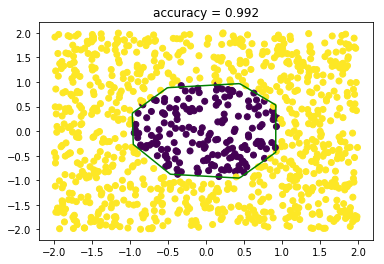

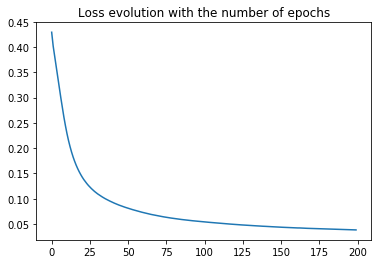


 Test data 



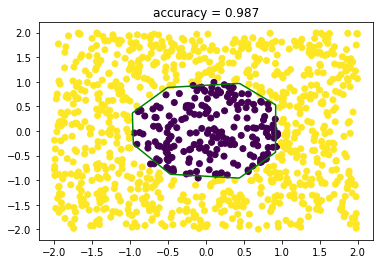

In [22]:
parameters, loss = gradient_descent(data_train, dh=4, K=10, n_epoch=200, learning_rate=0.03)
print('\n Training data \n')
plot_decision_boundary(data_train, parameters)
plot_loss_evolution(loss, n_epoch=200)
print('\n Test data \n')
plot_decision_boundary(data_test, parameters)


 Duration of the training =  12.038864850997925  seconds 


 Mean duration of an epoch =  0.06019432425498963  seconds 


 Training data 



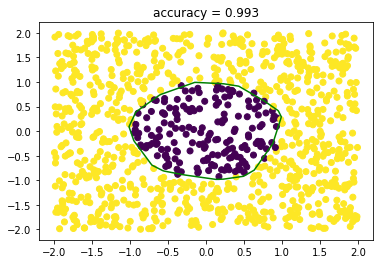

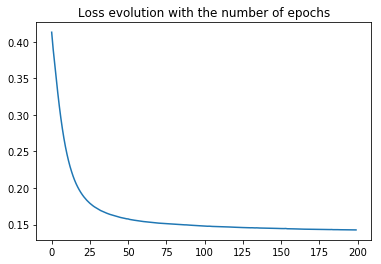


 Test data 



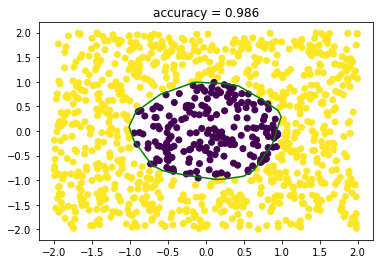

In [11]:
parameters, loss = gradient_descent(data_train, dh=10, K=10, n_epoch=200, learning_rate=0.03, use_regularization=True, lmbda=[1e-3]*4)
print('\n Training data \n')
plot_decision_boundary(data_train, parameters)
plot_loss_evolution(loss, n_epoch=200)
print('\n Test data \n')
plot_decision_boundary(data_test, parameters)

# Implémentation matricielle

Pour l'implémentation matricielle, nous allons travailler au sein d'une classe "Neural Network"

### Question 6 & 9

In [34]:
class NN:
    
    def __init__(self, d, dh, m, Lambda=[0,0,0,0]):
        
        """Initialize the parameters of the NN"""
        
        self.d = d
        self.dh = dh
        self.m = m
        
        self.lambda_11 = Lambda[0]
        self.lambda_12 = Lambda[1]
        self.lambda_21 = Lambda[2]
        self.lambda_22 = Lambda[3]
    
        self.W1 = np.random.uniform(low=(-1/np.sqrt(d)), high=(1/np.sqrt(d)), size=(dh,d))
        self.b1 = np.zeros((dh,1))
        self.W2 = np.random.uniform(low=(-1/np.sqrt(dh)), high=(1/np.sqrt(dh)), size=(m,dh))
        self.b2 = np.zeros((m,1))
        
        self.ha = None
        self.hs = None
        self.oa = None
        self.os = None
        
        self.loss_memory_test = []
        self.accuracy_memory_test = []
        self.loss_memory_train = []
        self.accuracy_memory_train = []
        
    def compute_R_hat(self,Y):
        
        """Compute the loss $\hat{R}$ for a given output matrix of probability os and the true Y"""
        
        n = len(Y)
        return(-np.sum(np.log([self.os[Y[i], i] for i in range(n)]))/n)
    
    def compute_regularisation(self, regularize=False):
        
        """Compute the regularisation term"""
        
        if regularize:
               
            return(self.lambda_11*np.sum(np.abs(self.W1)) + self.lambda_12*np.sum(self.W1*self.W1) + self.lambda_21*np.sum(np.abs(self.W2)) + self.lambda_22*np.sum(self.W2*self.W2))
               
        else:
            
            return(0)
    
    def loss(self, Y, regularize=False):
        
        """Compute the loss $\tilde{R}$ for a given output matrix of probability os and the true Y"""
        
        return(self.compute_R_hat(Y) + self.compute_regularisation(regularize))
    
    def fprop(self, X):
        
        """Execute the forward propagation"""

        self.ha = self.W1.dot(X) + self.b1
        self.hs = RELU(self.ha)
        self.oa = self.W2.dot(self.hs) + self.b2
        self.os = softmax(self.oa)
    
    def bprop(self, X, Y, learning_rate, regularize=False):
        
        """Execute the backward propagation"""
        
        n = len(Y)
        grad_oa = self.os.copy()
        grad_oa[Y, range(n)] -= 1
        grad_b2 = 1/n * np.sum(grad_oa, axis=1, keepdims=True)
        grad_W2 = 1/n * np.dot(grad_oa, self.hs.T)
        grad_hs = self.W2.T.dot(grad_oa)
        grad_ha = grad_hs * (self.ha>0)
        grad_b1 = 1/n * np.sum(grad_ha, axis=1, keepdims=True)
        grad_W1 = 1/n * np.dot(grad_ha, X.T)
        
        # If we have a regularizaion term
        
        if regularize:
            
            grad_W2 += self.lambda_21*(1*(self.W2 > 0) - 1*(self.W2 <0)) + self.lambda_22*2*self.W2
            grad_W1 += self.lambda_11*(1*(self.W1 > 0) - 1*(self.W1 <0)) + self.lambda_12*2*self.W1
        
        self.W1 -= learning_rate*grad_W1
        self.b1 -= learning_rate*grad_b1
        self.W2 -= learning_rate*grad_W2
        self.b2 -= learning_rate*grad_b2
    
    def gradient_descent(self, data_train, data_test, K, n_epoch, learning_rate, use_regularization=False):
    
        """Use the gradient descent algorithm to train the Neural Network"""
    
        t1 = time.time()
        d = np.shape(data_train)[1] - 1
        X_test, Y_test = data_test[:,:d], data_test[:,-1]
        
        for t in range(n_epoch):
        
            np.random.shuffle(data_train)
            X_train, Y_train = data_train[:,:d], data_train[:,-1]
            n = len(Y_train)
        
            for k in range(n//K):
            
                X, Y = X_train[k*K:(k+1)*K], Y_train[k*K:(k+1)*K].astype(int)
                X = X.T
                self.fprop(X)
                self.bprop(X, Y, learning_rate, regularize=use_regularization)
            
            # metrics on train set
            
            self.fprop(X_train.T)
            self.loss_memory_train.append(self.loss(Y_train.astype(int), regularize=use_regularization))
            self.accuracy_memory_train.append(self.compute_accuracy(data_train, self.os))
            
            # metrics on test set
            
            self.fprop(X_test.T)
            self.loss_memory_test.append(self.loss(Y_test.astype(int), regularize=use_regularization))
            self.accuracy_memory_test.append(self.compute_accuracy(data_test, self.os))
    
        t2 = time.time()
        print('\n Duration of the training = ', t2-t1, ' seconds \n')
        print('\n Mean duration of an epoch = ', (t2-t1)/n_epoch, ' seconds \n')
        self.plot_metrics_evolution(n_epoch)
    
    def compute_accuracy(self, data, probas):
        
        d = np.shape(data)[1] - 1
        X, y = data[:, :d], data[:, -1]
        y_predict = []
        
        for k in range(len(X)):
        
            y_predict.append(np.argmax(probas[:,k]))
        
        accuracy = np.mean(np.array(1*(y==y_predict)))
        
        return(accuracy)
        

    def plot_decision_boundary(self,data):
    
        X, y = data[:, :2], data[:, -1]
        y_predict = []
        y_echantillonage = []
        self.fprop(X.T)
        probas = self.os
        accuracy = self.compute_accuracy(data, probas)
        plt.scatter(X[:,0], X[:,1], c=y)
    
        # We create a 2-d grid
    
        borne_inf = np.min(X)
        borne_sup = np.max(X)
        x1 = np.linspace(borne_inf, borne_sup, 200)
        x2 = np.linspace(borne_inf, borne_sup, 200)
        X_echantillonage = np.reshape([[[i,j] for i in x1] for j in x2], (len(x1)*len(x2), 2))
        self.fprop(X_echantillonage.T)
    
        for k in range(len(X_echantillonage)):
        
            y_echantillonage.append(self.os[0,k])
    
        plt.contour(x1, x2, np.reshape(y_echantillonage, (len(x1), len(x2))), [0.5], colors='g')
        plt.title('accuracy = '+str(accuracy))
        plt.show()
        
    def plot_metrics_evolution(self, n_epoch):
        
        plt.figure(1,figsize=(8,8))
        plt.subplot(211)
        plt.plot(range(n_epoch), self.loss_memory_train, label='train loss',color='b')
        plt.plot(range(n_epoch), self.loss_memory_test, label='test loss', color = 'r')
        plt.title('Loss evolution with the number of epochs')
        plt.legend()
        plt.subplot(212)
        plt.plot(range(n_epoch), self.accuracy_memory_train, label='accuracy train', color = 'g')
        plt.plot(range(n_epoch), self.accuracy_memory_test, label='accuracy test', color = 'c')
        plt.title('Accuracy evolution with the number of epochs')
        plt.legend()
        plt.show()


 Duration of the training =  2.915344476699829  seconds 


 Mean duration of an epoch =  0.014576722383499146  seconds 



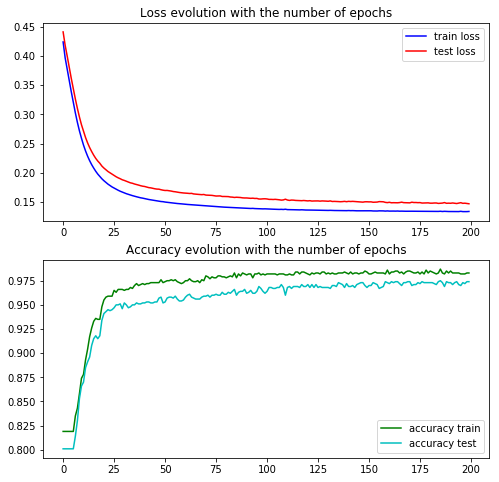


 Training data 



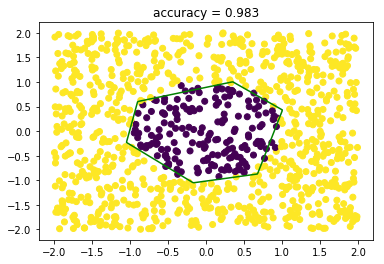


 Test data 



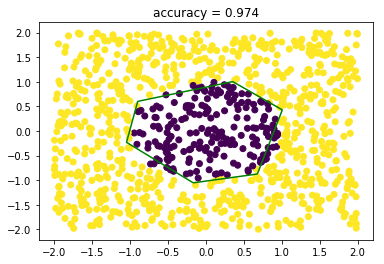

In [46]:
model = NN(2, 4, 2, Lambda=[1e-3]*4)
model.gradient_descent(data_train, data_test, K=10, n_epoch=200, learning_rate=0.03, use_regularization=True)
print('\n Training data \n')
model.plot_decision_boundary(data_train)
print('\n Test data \n')
model.plot_decision_boundary(data_test)

### Question 7

Pour comparer les gradients il faut commencer par initialiser les paramètres avec les même valeur, à savoir utiliser la commande $\texttt{random.seed}$.

### Question 8

Nous faisons que 20 epoch ici, le but étant de voir le temps qu'un epoch dûre et non pas de de fitter le modèle

* Les résultats pour le dataset MNIST avec la méthode par boucle


 Duration of the training =  107.91243362426758  seconds 


 Mean duration of an epoch =  5.395621681213379  seconds 



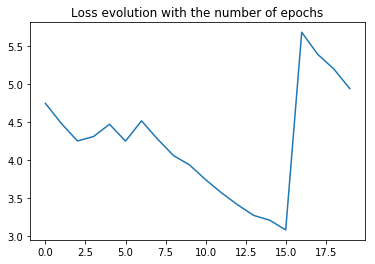

In [28]:
parameters, loss = gradient_descent(data_train_mnist, dh=10, K=100, n_epoch=20, learning_rate=0.03, use_regularization=True, lmbda=[1e-3]*4)
plot_loss_evolution(loss, n_epoch=20)

* Les résultats pour le dataset MNIST avec la méthode matricielle


 Duration of the training =  15.402961492538452  seconds 


 Mean duration of an epoch =  0.7701480746269226  seconds 



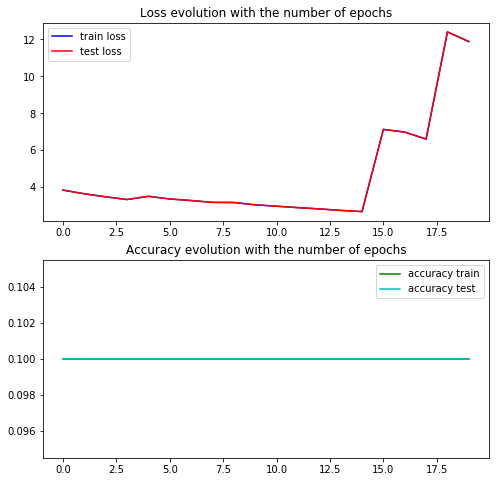

In [40]:
d = np.shape(data_train_mnist)[1] - 1
m = int(max(data_train_mnist[:,-1]) + 1)

model = NN(d, 10, m, Lambda=[1e-3]*4)
model.gradient_descent(data_train_mnist, data_test_mnist, K=100, n_epoch=20, learning_rate=0.03, use_regularization=True)

### Question 10

L:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
L:\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater
L:\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater
L:\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in less
L:\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater
L:\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in less



 Duration of the training =  77.70395588874817  seconds 


 Mean duration of an epoch =  0.7770395588874817  seconds 



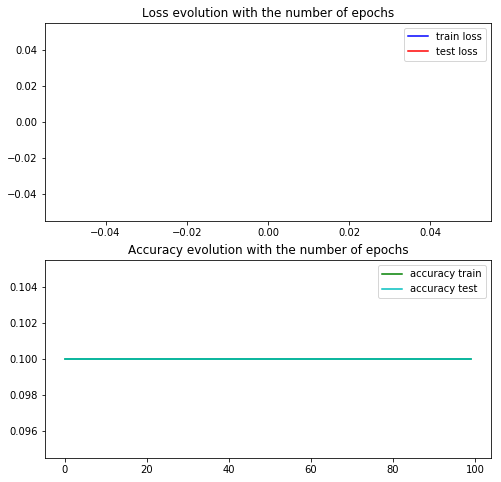

In [59]:
d = np.shape(data_train_mnist)[1] - 1
m = int(max(data_train_mnist[:,-1]) + 1)

model = NN(d, 10, m, Lambda=[1e-3]*4)
model.gradient_descent(data_train_mnist, data_test_mnist, K=100, n_epoch=100, learning_rate=0.03, use_regularization=True)

In [55]:
model.loss_memory_test

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]